In [1]:
from scipy.spatial.transform import Rotation
import numpy as np
import scipy
import pathlib
import h5py

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.stats import median_absolute_deviation as mad_
from astropy.coordinates import CartesianRepresentation, SphericalRepresentation
import gala.dynamics as gd
import gala.coordinates as gc
from mwlmc import model as mwlmc_model
Model = mwlmc_model.MWLMC()
import yaml

import matplotlib
import matplotlib.pyplot as plt
import os
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"
plt.style.use('my_standard.mplstyle')

galcen_v_sun = (11.1, 245, 7.3)*u.km/u.s
galcen_distance = 8.249*u.kpc

Initialising MW ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising LMC ... 
sphcoefs::read_coef_file: reading coefficients from file . . . success!!
Initialising MW disc ... 
cylcoefs::read_simple_coef_file: reading coefficients from file . . . success!!


sphcache::read_sph_cache: trying to read cached table . . . success!!
sphcache::read_sph_cache: trying to read cached table . . . success!!
cylcache::read_cyl_cache: trying to read cached table . . . success!!


In [2]:
def orbpole(xs,vs):
    uu = np.cross(xs, vs)
    uumag = np.linalg.norm(uu)
    u = uu.T/uumag
    b = np.arcsin(u[2])
    sinl = u[1]/np.cos(b)
    cosl = u[0]/np.cos(b)
    ll = np.arctan2(sinl, cosl)
    gl = np.degrees(ll)
    gb = np.degrees(b)
    return gl, gb    

def orbpole_singlevec(u):
    b = np.arcsin(u[2])
    sinl = u[1]/np.cos(b)
    cosl = u[0]/np.cos(b)
    ll = np.arctan2(sinl, cosl)
    gl = np.degrees(ll)
    gb = np.degrees(b)
    return gl, gb  

In [3]:
lmc_xs, lmc_vs = Model.expansion_centres(0.)[6:9], Model.expansion_centre_velocities(0.)[6:9]
disc_xs, disc_vs = Model.expansion_centres(0.)[:3], Model.expansion_centre_velocities(0.)[:3]

lmc_lpole, lmc_bpole = orbpole(np.array(lmc_xs), np.array(lmc_vs))
disc_lpole, disc_bpole = orbpole(np.array(disc_xs), np.array(disc_vs))
com_lpole, com_bpole = orbpole_singlevec(disc_xs)

def rotation_matrix_from_vectors(v1, v2):
    # Normalize the vectors
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    
    # Calculate the cosine and sine of the angle between the vectors
    cos_theta = np.dot(v1, v2)
    sin_theta = np.cross(v1, v2)
    
    # Construct the rotation matrix
    R = np.array([[cos_theta, -sin_theta],
                  [sin_theta, cos_theta]])
    return R

# Example usage
v1_lmc = np.array([lmc_lpole, lmc_bpole])
v1_disc = np.array([disc_lpole, disc_bpole])
v1_com = np.array([com_lpole, com_bpole])
v2 = np.array([0, 90])

rotation_matrix_lmc = rotation_matrix_from_vectors(v1_lmc, v2)
rotation_matrix_disc = rotation_matrix_from_vectors(v1_disc, v2)
rotation_matrix_com = rotation_matrix_from_vectors(v1_com, v2)

rotation_matrix_lmc, rotation_matrix_disc, rotation_matrix_com

(array([[-0.02130971, -0.99977292],
        [ 0.99977292, -0.02130971]]),
 array([[-0.9850518 ,  0.17225841],
        [-0.17225841, -0.9850518 ]]),
 array([[-0.56870386, -0.82254235],
        [ 0.82254235, -0.56870386]]))

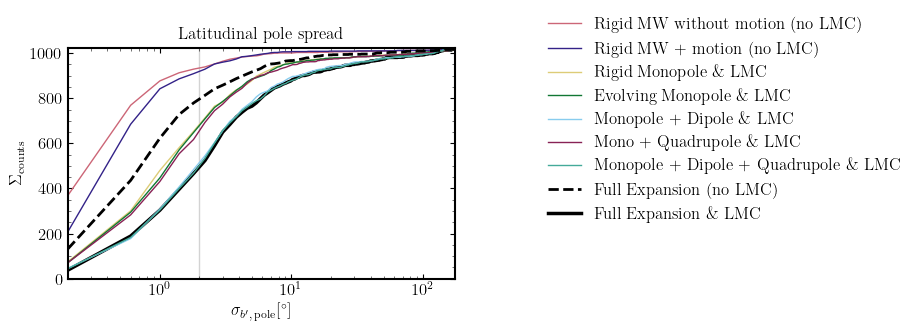

In [44]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
plotname= '1d-hists-cumulative' 

fig, ax = plt.subplots(1,1, figsize=(5,3))


potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                       'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                        'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5'])

# potentials = list(['rigid-mw.hdf5',])

labels = list(['Rigid MW without motion (no LMC)', 'Rigid MW + motion (no LMC)', 'Rigid Monopole \& LMC', 'Evolving Monopole \& LMC', \
               'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', 'Monopole + Dipole + Quadrupole \& LMC',\
               'Full Expansion (no LMC)', 'Full Expansion \& LMC'])
# labels = list(['Rigid MW without motion (no LMC)'])

for j in range(len(potentials)): 

    with h5py.File(path + potentials[j],'r') as file:
        
        t_idx = -1
        l_pole = np.array(file['pole_l'])[:,t_idx]
        b_pole = np.array(file['pole_b'])[:,t_idx]
        
        poles =  np.stack((l_pole, b_pole))
    rot_pole = np.array([rotation_matrix @ poles[:,i] for i in range(len(l_pole))])

    # asymmetry
    h, bin_edges = np.histogram(np.nanstd(rot_pole[:,1],axis=1), bins=np.linspace(0, 200, 500))
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
    if j==8:
        plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
    elif j==7:
        plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
    else:
        plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        
    plt.vlines(2, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
    plt.xlabel(r'$\sigma_{b^{\prime},\,{\mathrm{pole}}}[^{\circ}]$')
    plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
    plt.xlim(0.2,175)
    plt.xscale('log')
    plt.ylim(0,1024)
    plt.title('Latitudinal pole spread')
    plt.legend(frameon=False, ncol=1, fontsize=12, bbox_to_anchor=(1.2,1.2))

In [8]:
def plt_1dhists_cumulative(path, plotname, savefig=False):
    fig, ax = plt.subplots(4,2, figsize=(10,12))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                           'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                            'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5'])

    labels = list(['Rigid MW without motion (no LMC)', 'Rigid MW + motion (no LMC)', 'Rigid Monopole \& LMC', 'Evolving Monopole \& LMC', \
                   'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', 'Monopole + Dipole + Quadrupole \& LMC', 'Full Expansion (no LMC)', 'Full Expansion \& LMC'])

    for j in range(len(potentials)): 

        with h5py.File(path + potentials[j],'r') as file:
            lengths = np.array(file['lengths'])
            widths = np.array(file['widths'])
            loc_veldis = np.array(file['loc_veldis'])
            # energies = np.array(file['energies'])
            track_deform = np.array(file['track_deform'])
            # Ls = np.array(file['L'])
            # Lzs = np.array(file['Lz'])
            
            lons = np.array(file['lons'])
            l_lead = np.nanpercentile(lons, 95, axis=1)
            l_trail = np.nanpercentile(lons, 5, axis=1)
            asymmetry = np.abs(l_lead/l_trail)
            
            t_idx = -1
            l_pole = np.array(file['pole_l'])[:,t_idx]
            # l_pole_std = np.nanstd(l_pole, axis=1)
            b_pole = np.array(file['pole_b'])[:,t_idx]
            # b_pole_std = np.nanstd(b_pole, axis=1)
        
            poles =  np.stack((l_pole, b_pole))
        rot_pole = np.array([rotation_matrix_lmc @ poles[:,i] for i in range(len(l_pole))])
        l_pole_std, b_pole_std = np.nanstd(rot_pole[:,0],axis=1), np.nanstd(rot_pole[:,1],axis=1)

        # lengths
        plt.sca(ax[0,0])
        h, bin_edges = np.histogram(lengths, bins=np.linspace(-1, 360, 100))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.xlabel(r'$l_{\mathrm{stream}}\,[^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0, 360)
        plt.ylim(0,1024)
        plt.xscale('log')
        # plt.legend(frameon=False, ncol=3, fontsize=12, bbox_to_anchor=(2.7,1.75))
        plt.title('Length')

        #widths
        plt.sca(ax[0,1])
        h, bin_edges = np.histogram(widths, bins=np.linspace(0., 3, 100))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(0.5, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$w\,[^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0,)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Width')

        # velocity dispersion
        plt.sca(ax[1,0])
        h, bin_edges = np.histogram(loc_veldis, bins=np.linspace(0, 20, 100))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2.5, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{v}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0,20)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Local velocity dispersion')
        
        # track deformation
        plt.sca(ax[1,1])
        h, bin_edges = np.histogram(track_deform, bins=np.linspace(-0., 10, 100))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(1, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\bar{\delta}\,[^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.,)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Deviation from Great Circle')
        
        # median l pole spread
        plt.sca(ax[2,0])
        h, bin_edges = np.histogram(l_pole_std, bins=np.linspace(0, 10, 500))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{l^{\prime},\,{\mathrm{pole}}}[^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.02,10)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Longitudinal pole spread')
        
        # median b pole spread
        plt.sca(ax[2,1])
        h, bin_edges = np.histogram(b_pole_std, bins=np.linspace(0, 180, 800))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{b^{\prime},\,{\mathrm{pole}}}[^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.2,180)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Latitudinal pole spread')
        
        # asymmetry
        plt.sca(ax[3,0])
        h, bin_edges = np.histogram(asymmetry, bins=np.linspace(0, 11, 300))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.xlabel(r'$l_{\mathrm{leading}}/l_{\mathrm{trailing}}$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.09, 11)
        plt.xscale('log')
        plt.ylim(0,1024)
        plt.title('Asymmetry')
        plt.legend(frameon=False, ncol=1, fontsize=12, bbox_to_anchor=(1.2,1.2))
        # Median distance to stream
        # plt.sca(ax[3,1])
        ax[3,1].set_visible(False)
        
    if savefig==False:
        return
    elif savefig==True:
        savepath = '/mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/{}'.format(plotname)
        print('* Saving figure at {}.pdf'.format(savepath))
        plt.savefig(savepath)
    # plt.close()

/tmp/ipykernel_1664700/4049557037.py:50: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 360)
/tmp/ipykernel_1664700/4049557037.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,)
/tmp/ipykernel_1664700/4049557037.py:89: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,20)
/tmp/ipykernel_1664700/4049557037.py:108: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,)


* Saving figure at /mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/1d-hists-cumulative.pdf


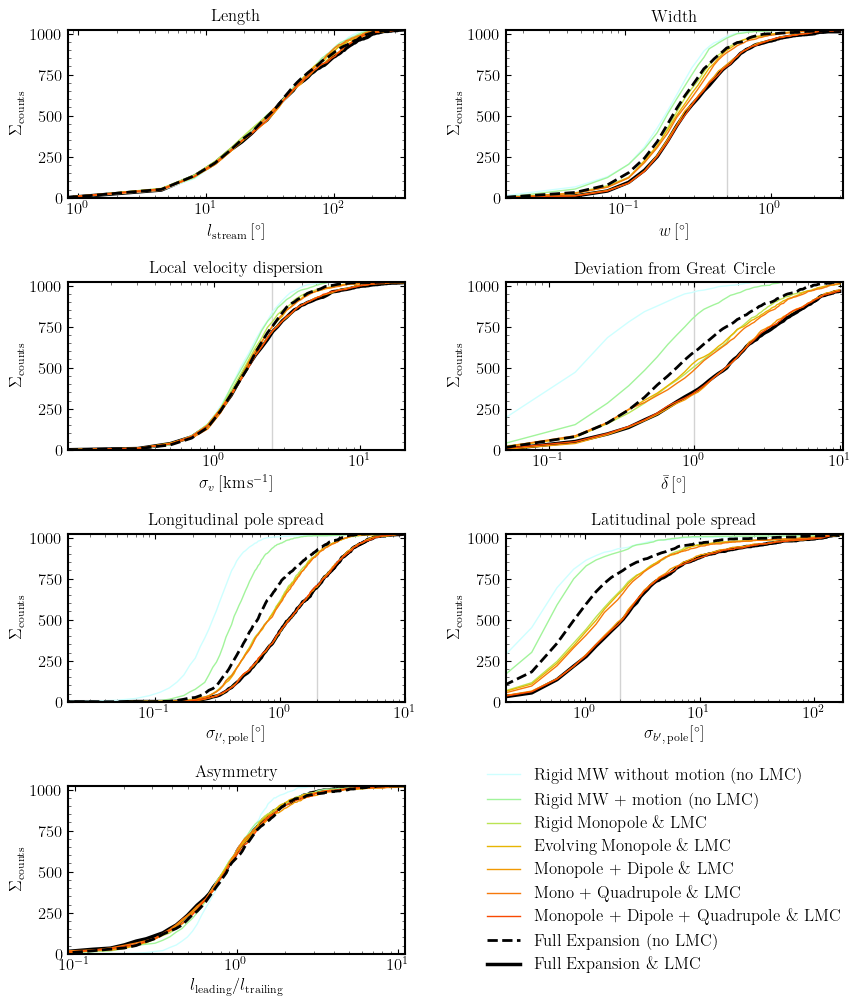

In [9]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
plotname= '1d-hists-cumulative' 

plt_1dhists_cumulative(path, plotname, True)

Is there a preferred direction for orbital poles to spread out in?

In [44]:
def orbpole_spreads(path, plotname, savefig=False):
    fig, ax = plt.subplots(3,2, figsize=(10,10))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                           'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                            'full-MWhalo-full-MWdisc-no-LMC.hdf5', 'Full-MWhalo-MWdisc-LMC.hdf5'])

    labels = list(['Rigid MW without motion (no LMC)', 'Rigid MW + motion (no LMC)', 'Rigid Monopole \& LMC', 'Evolving Monopole \& LMC', \
                   'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', 'Monopole + Dipole + Quadrupole \& LMC', 'Full Expansion (no LMC)', 'Full Expansion \& LMC'])

    for j in range(len(potentials)): 

        with h5py.File(path + potentials[j],'r') as file:

            t_idx = -1
            l_pole = np.array(file['pole_l'])[:,t_idx]
            b_pole = np.array(file['pole_b'])[:,t_idx]
            poles =  np.stack((l_pole, b_pole))
            
        rot_pole_lmc = np.array([rotation_matrix_lmc @ poles[:,i] for i in range(len(l_pole))])
        l_pole_std_lmc, b_pole_std_lmc = np.nanstd(rot_pole_lmc[:,0],axis=1), np.nanstd(rot_pole_lmc[:,1],axis=1)
        
        rot_pole_disc = np.array([rotation_matrix_disc @ poles[:,i] for i in range(len(l_pole))])
        l_pole_std_disc, b_pole_std_disc = np.nanstd(rot_pole_disc[:,0],axis=1), np.nanstd(rot_pole_disc[:,1],axis=1)
                                                                                        
        rot_pole_com = np.array([rotation_matrix_com @ poles[:,i] for i in range(len(l_pole))])
        l_pole_std_com, b_pole_std_com = np.nanstd(rot_pole_com[:,0],axis=1), np.nanstd(rot_pole_com[:,1],axis=1)                                                                                

        #----------------------------------------------------------------------------------------------------------
        ### LMC pole frame
        #----------------------------------------------------------------------------------------------------------
        
        # median l pole spread - LMC frame
        plt.sca(ax[0,0])
        h, bin_edges = np.histogram(l_pole_std_lmc, bins=np.linspace(0, 10, 500))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{l, \, {\mathrm{pole}}} [^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.02,10)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Longitudinal pole spread - LMC frame')
        
        # median b pole spread - LMC frame
        plt.sca(ax[0,1])
        h, bin_edges = np.histogram(b_pole_std_lmc, bins=np.linspace(0, 180, 1000))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{b, \, {\mathrm{pole}}} [^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.2,180)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Latitudinal pole spread - LMC frame')
        
        #----------------------------------------------------------------------------------------------------------
        ### Disc pole frame
        #----------------------------------------------------------------------------------------------------------
        
        # median l pole spread - disc frame
        plt.sca(ax[1,0])
        h, bin_edges = np.histogram(l_pole_std_disc, bins=np.linspace(0, 180, 1000))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{l, \, {\mathrm{pole}}} [^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.2,180)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Longitudinal pole spread - Disc frame')
        
        # median b pole spread - disc frame
        plt.sca(ax[1,1])
        h, bin_edges = np.histogram(b_pole_std_disc, bins=np.linspace(0, 10, 500))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{b, \, {\mathrm{pole}}} [^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.02,10)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Latitudinal pole spread - Disc frame')
        plt.legend(frameon=False, ncol=1, fontsize=12, bbox_to_anchor=(1.2,1.1))
        
        #----------------------------------------------------------------------------------------------------------
        ### COM pole frame
        #----------------------------------------------------------------------------------------------------------
        
        # median l pole spread - COM frame
        plt.sca(ax[2,0])
        h, bin_edges = np.histogram(l_pole_std_com, bins=np.linspace(0, 100, 1000))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{l, \, {\mathrm{pole}}} [^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.1,100)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Longitudinal pole spread - Motion frame')
        
        # median b pole spread - COM frame
        plt.sca(ax[2,1])
        h, bin_edges = np.histogram(b_pole_std_com, bins=np.linspace(0, 15, 500))
        bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
        if j==8:
            plt.plot(bin_mids, np.cumsum(h), lw=2.5, color='k', label=labels[j], zorder=1)
        elif j==7:
            plt.plot(bin_mids, np.cumsum(h), lw=2, ls='dashed', color='k', label=labels[j])
        else:
            plt.plot(bin_mids, np.cumsum(h), lw=1, label=labels[j], zorder=2)
        plt.vlines(2, 0, 1024, color='lightgrey', ls='solid', lw=.75, zorder=0.5)
        
        plt.xlabel(r'$\sigma_{b, \, {\mathrm{pole}}} [^{\circ}]$')
        plt.ylabel(r'$\Sigma_{\mathrm{counts}}$')
        plt.xlim(0.1,15)
        plt.ylim(0,1024)
        plt.xscale('log')
        plt.title('Latitudinal pole spread - Motion frame')
        
    if savefig==False:
        return
    elif savefig==True:
        savepath = '/mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/{}'.format(plotname)
        print('* Saving figure at {}.pdf'.format(savepath))
        plt.savefig(savepath)

* Saving figure at /mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/orbpole-spreads.pdf


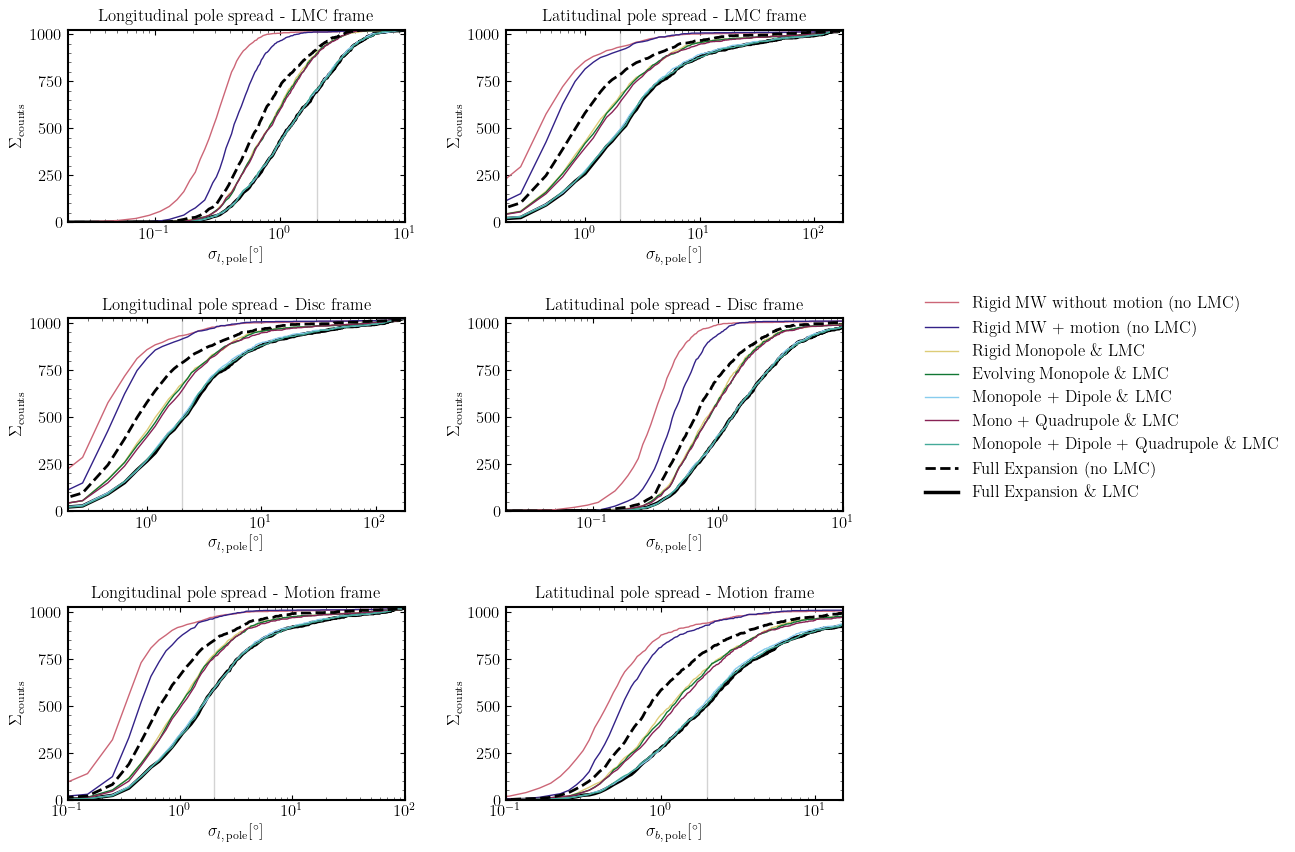

In [46]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
plotname= 'orbpole-spreads' 

orbpole_spreads(path, plotname, True)

In [14]:
# def plt_1dhists_reltostatic(path, plotname, savefig=False):
#     fig, ax = plt.subplots(2,3, figsize=(13,5.5))
#     plt.subplots_adjust(hspace=0.3, wspace=0.3)

# #     potentials = list(['rigid-mw.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
# #                            'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
# #                            'Full-MWhalo-MWdisc-LMC.hdf5', 'full-MWhalo-full-MWdisc-no-LMC.hdf5'])

# #     labels = list(['Rigid MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
# #                    'Monopole + Dipole + Quadrupole', 'Full Expansion', 'Full Expansion (no LMC)'])
    
#     potentials = list(['rigid-mw.hdf5','static-mw.hdf5', 'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5',
#                         'Full-MWhalo-MWdisc-LMC.hdf5', 'full-MWhalo-full-MWdisc-no-LMC.hdf5'])

#     labels = list(['Rigid MW (no motion)','Rigid MW (with motion)', 'Monopole + Dipole \& LMC', 'Mono + Quadrupole \& LMC', 
#                 'Full Expansion \& LMC', 'Full Expansion (no LMC)'])
    
#     with h5py.File(path + potentials[0],'r') as file:

#             lengths_0 = np.array(file['lengths'])
#             widths_0 = np.array(file['widths'])
#             loc_veldis_0 = np.array(file['loc_veldis'])
#             track_deform_0 = np.array(file['track_deform'])
          
#             t_idx = -1
#             l_pole = np.array(file['pole_l'])[:,t_idx]
#             l_pole_std_0 = np.nanstd(l_pole, axis=1)
#             b_pole = np.array(file['pole_b'])[:,t_idx]
#             b_pole_std_0 = np.nanstd(b_pole, axis=1)

#     for j in range(0, len(potentials)): 

#         with h5py.File(path + potentials[j],'r') as file:
#             lengths = np.array(file['lengths'])
#             widths = np.array(file['widths'])
#             loc_veldis = np.array(file['loc_veldis'])
#             track_deform = np.array(file['track_deform'])
         
#             t_idx = -1
#             l_pole = np.array(file['pole_l'])[:,t_idx]
#             l_pole_std = np.nanstd(l_pole, axis=1)
#             b_pole = np.array(file['pole_b'])[:,t_idx]
#             b_pole_std = np.nanstd(b_pole, axis=1)

#         # lengths
#         plt.sca(ax[0,0])
#         h, bin_edges = np.histogram(lengths, bins=np.linspace(-1, 360, 10))
#         h_0, bin_edges_0 = np.histogram(lengths_0, bins=np.linspace(-1, 360, 10))
#         bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
#         plt.plot(bin_mids, h - h_0, label=labels[j])
#         plt.xlabel(r'$l\,[^{\circ}]$')
#         plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
#         plt.xlim(0, 360)
#         # plt.ylim(0.1,)
#         plt.legend(frameon=False, ncol=3, fontsize=12, bbox_to_anchor=(3.,1.35))

#         #widths
#         plt.sca(ax[1,0])
#         h, bin_edges = np.histogram(widths, bins=np.linspace(-0., 3, 15))
#         h_0, bin_edges_0 = np.histogram(widths_0, bins=np.linspace(-0., 3, 15))
#         bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
#         plt.plot(bin_mids, h - h_0)
#         plt.xlabel(r'$w\,[^{\circ}]$')
#         plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
#         plt.xlim(0,)
#         # plt.ylim(0.1,)

#         # velocity dispersion
#         plt.sca(ax[0,1])
#         h, bin_edges = np.histogram(loc_veldis, bins=np.linspace(-0, 20, 15))
#         h_0, bin_edges_0 = np.histogram(loc_veldis_0, bins=np.linspace(-0, 20, 15))
#         bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
#         plt.plot(bin_mids, h - h_0)
#         plt.xlabel(r'$\sigma_{v}\,[\mathrm{km}\,\mathrm{s}^{-1}]$')
#         plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
#         plt.xlim(0,20)
#         # plt.ylim(0.1,)
        
#         # track deformation
#         plt.sca(ax[1,1])
#         h, bin_edges = np.histogram(track_deform, bins=np.linspace(-0., 10, 25))
#         h_0, bin_edges_0 = np.histogram(track_deform_0, bins=np.linspace(-0, 10, 25))
#         bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
#         plt.plot(bin_mids, h - h_0)
#         plt.xlabel(r'$\bar{\delta}\,[^{\circ}]$')
#         plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
#         plt.xlim(-0.,)
#         # plt.ylim(0.1,)

#         # median l pole spread
#         plt.sca(ax[0,2])
#         h, bin_edges = np.histogram(l_pole_std, bins=np.linspace(0, 50, 30))
#         h_0, bin_edges_0 = np.histogram(l_pole_std_0, bins=np.linspace(0, 50, 30))
#         bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
#         plt.plot(bin_mids, h - h_0)
#         plt.xlabel(r'$\sigma_{l,\,{\mathrm{pole}}}[^{\circ}]$')
#         plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
#         plt.xlim(0,25)
#         # plt.ylim(0.1,)
        
#         # median b pole spread
#         plt.sca(ax[1,2])
#         h, bin_edges = np.histogram(b_pole_std, bins=np.linspace(0, 10, 20))
#         h_0, bin_edges_0 = np.histogram(b_pole_std_0, bins=np.linspace(0, 10, 20))
#         bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
#         plt.plot(bin_mids, h - h_0)
#         plt.xlabel(r'$\sigma_{b,\,{\mathrm{pole}}}[^{\circ}]$')
#         plt.ylabel('$\mathrm{N} - \mathrm{N_{0}}$')
#         plt.xlim(0,10)
#         # plt.ylim(0.1,)
        
#     if savefig==False:
#         return
#     elif savefig==True:
#         savepath = '/mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/{}'.format(plotname)
#         print('* Saving figure at {}.pdf'.format(savepath))
#         plt.savefig(savepath)
#     # plt.close()

In [15]:
# path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
# plotname= '1d-hists-reltorigid' 

# plt_1dhists_reltostatic(path, plotname, True)

In [62]:
def plt_1dhists_quadrants(path, plotname, savefig=False):
    
    potentials = list(['static-mwh-only.hdf5','rm-MWhalo-full-MWdisc-full-LMC.hdf5', 'em-MWhalo-full-MWdisc-full-LMC.hdf5',\
                           'md-MWhalo-full-MWdisc-full-LMC.hdf5', 'mq-MWhalo-full-MWdisc-full-LMC.hdf5', 'mdq-MWhalo-full-MWdisc-full-LMC.hdf5',\
                           'Full-MWhalo-MWdisc-LMC.hdf5', 'full-MWhalo-full-MWdisc-no-LMC.hdf5'])
    
    labels = list(['Static MW','Static Monopole', 'Evolving Monopole', 'Monopole + Dipole', 'Mono + Quadrupole', \
                   'Monopole + Dipole \n + Quadrupole', 'Full Expansion', 'Full Expansion \n (no LMC)'])
    
    quadrants = list(['Q1', 'Q2', 'Q3', 'Q4'])
    
    fig, ax = plt.subplots(6,len(potentials), figsize=(24,12))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    for j in range(len(potentials)): 

        with h5py.File(path + potentials[j],'r') as file:
            
            l_gc,b_gc  = np.array(file['l_gc']), np.array(file['b_gc'])
            mask_q1 = ( (l_gc > 0) & (l_gc < 180) & (b_gc > 0) & (b_gc < 90) )
            mask_q2 = ( (l_gc > 180) & (l_gc < 360) & (b_gc > 0) & (b_gc < 90) )
            mask_q3 = ( (l_gc > 0) & (l_gc < 180) & (b_gc > -90) & (b_gc < 0) )
            mask_q4 = ( (l_gc > 180) & (l_gc < 360) & (b_gc > -90) & (b_gc < 0) )
            
            masks = [mask_q1, mask_q2, mask_q3, mask_q4]
            
            lengths = np.array(file['lengths'])
            widths = np.array(file['widths'])
            loc_veldis = np.array(file['loc_veldis'])
            energies = np.array(file['energies'])
            track_deforms = np.array(file['track_deform'])
            Ls = np.array(file['L'])
            Lzs = np.array(file['Lz'])
            
            # print(track_deforms)
            
        for m in range(len(masks)):
        
            # lengths
            plt.sca(ax[0,j])
            h, bin_edges = np.histogram(lengths[masks[m]], bins=np.linspace(-1, 360, 10))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h, label=quadrants[m])
            plt.xlabel(r'$l\,[^{\circ}]$')
            plt.xlim(0, 360)
            plt.ylim(0.1,)
            if j==0:
                plt.legend(frameon=False,fontsize=10)

            #widths
            plt.sca(ax[1,j])
            h, bin_edges = np.histogram(widths[masks[m]], bins=np.linspace(0, 3, 15))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h)
            plt.xlabel(r'$w\,[^{\circ}]$', fontsize=14)
            plt.xlim(0,)
            plt.ylim(0.1,)

            # velocity dispersion
            plt.sca(ax[2,j])
            h, bin_edges = np.histogram(loc_veldis[masks[m]], bins=np.linspace(0, 20, 15))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h)
            plt.xlabel(r'$\sigma_{v}\,[\mathrm{km}\,\mathrm{s}^{-1}]$', fontsize=14)
            plt.xlim(0,20)
            plt.ylim(0.1,)
            
            # track deforms
            plt.sca(ax[3,j])
            h, bin_edges = np.histogram(track_deforms[masks[m]], bins=np.linspace(-0., 10,15))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h)
            plt.xlabel(r'$\bar{\delta}\,[^{\circ}]$', fontsize=14)
            plt.ylim(0.1,)

            # median energies
            plt.sca(ax[4,j])
            h, bin_edges = np.histogram(np.log10(-energies)[masks[m]], bins=np.linspace(4, 5.5, 25))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h)
            plt.xlabel(r'$\log_{10}(\bar{E})\,[(\mathrm{km}\,\mathrm{s}^{-1})^2]$', fontsize=14)
            plt.xlim(4,5.5)
            plt.ylim(0.1,)

            # # median L
            # plt.sca(ax[4,j])
            # h, bin_edges = np.histogram(Ls[masks[m]], bins=np.linspace(0, 6500, 20))
            # bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            # plt.plot(bin_mids, h)
            # plt.xlabel(r'$L\,[\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{kpc}]$', fontsize=14)
            # plt.ylim(0.1,)

            # median Lz
            plt.sca(ax[5,j])
            h, bin_edges = np.histogram(Lzs[masks[m]], bins=np.linspace(-6000, 6000, 20))
            bin_mids = (bin_edges[:-1] + bin_edges[1:]) /2
            plt.plot(bin_mids, h)
            plt.xlabel(r'$L_{z}\,[\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{kpc}]$', fontsize=14)
            plt.ylim(0.1,)
        
    #-------------------------------------------------------------------------------------
    ### Plot cosmetics
    #-------------------------------------------------------------------------------------
    for k in range(len(labels)):
        ax[0,k].set_title(labels[k], fontsize=14)
        
    for l in range(6):
        ax[l, 0].set_ylabel('Counts', fontsize=14)
        
    if savefig==False:
        return
    elif savefig==True:
        savepath = '/mnt/ceph/users/rbrooks/oceanus/analysis/figures/histograms/{}'.format(plotname)
        print('* Saving figure at {}.pdf'.format(savepath))
        plt.savefig(savepath)
    # plt.close()

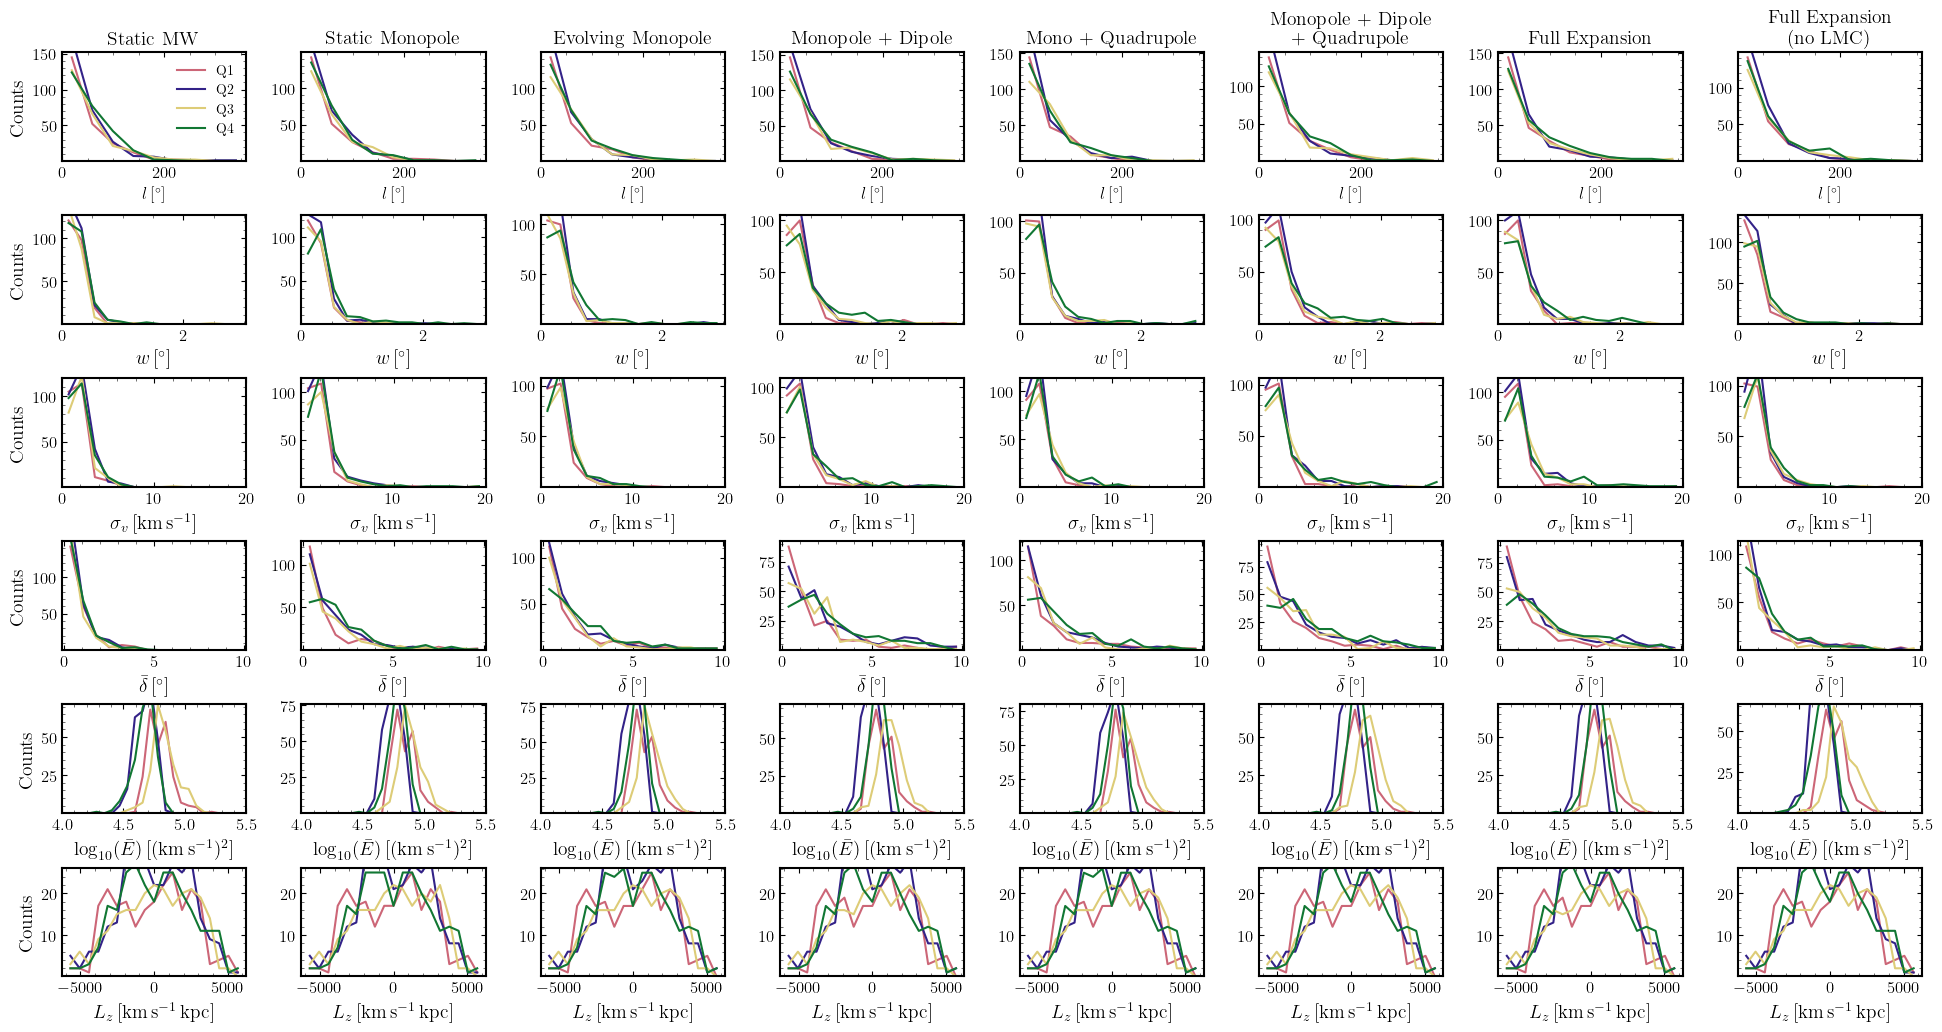

In [63]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/plotting_data/1024-dthalfMyr-10rpmin-75ramax/'
plotname= '1d-hists-quad' 

plt_1dhists_quadrants(path, plotname, False)

Calculating the proper motion misalignment angles

In [18]:
def lons_lats(pos, vel):
    prog = gd.PhaseSpacePosition(pos[0] * u.kpc, vel[0] * u.km / u.s)
    stream = gd.PhaseSpacePosition(pos[1:].T * u.kpc, vel[1:].T * u.km / u.s)
    R1 = Rotation.from_euler("z", -prog.spherical.lon.degree, degrees=True)
    R2 = Rotation.from_euler("y", prog.spherical.lat.degree, degrees=True)
    R_prog0 = R2.as_matrix() @ R1.as_matrix()  

    new_vxyz = R_prog0 @ prog.v_xyz
    v_angle = np.arctan2(new_vxyz[2], new_vxyz[1])
    R3 = Rotation.from_euler("x", -v_angle.to_value(u.degree), degrees=True)
    R = (R3 * R2 * R1).as_matrix()

    stream_rot = gd.PhaseSpacePosition(stream.data.transform(R))
    stream_sph = stream_rot.spherical
    lon = stream_sph.lon.wrap_at(180*u.deg).degree
    lat = stream_sph.lat.degree
    return lon, lat

In [147]:
def pm_misalignment(lons, xfs, vfs):
    # Compute percentiles
    lower_value = np.nanpercentile(lons, 0.1)
    upper_value = np.nanpercentile(lons, 99.9)
    # Filter lons_mainbody
    lons_mainbody = lons[(lons >= lower_value) & (lons <= upper_value)]
    xfs_mainbody = xfs[1:][(lons >= lower_value) & (lons <= upper_value)] 
    vfs_mainbody = vfs[1:][(lons >= lower_value) & (lons <= upper_value)] 
    # Create bins
    lon_bins = np.linspace(np.nanmin(lons_mainbody), np.nanmax(lons_mainbody), 50)
    # Compute angular momentum vectors and normalise
    L = np.cross(xfs_mainbody, vfs_mainbody, axis=1)
    Lmag = np.linalg.norm(L, axis=1)
    L_norm = L.T/Lmag
    
    # Slice lons_mainbody into bins
    bin_indices = np.digitize(lons_mainbody, lon_bins)
    # Create a mask array for lon bins
    mask = np.zeros((len(lons_mainbody), len(lon_bins) - 1), dtype=bool)
    for i in range(1, len(lon_bins)):
        mask[:, i - 1] = (bin_indices == i)

    # Calculate median for each bin
    Lnorm_bins = np.array([np.nanmedian(L_norm.T[m], axis=0) for m in mask.T])[1:]
    
    xs_bins = np.array([np.nanmedian(xfs_mainbody[m], axis=0) for m in mask.T])
    J_bins = np.array([np.cross(xs_bins[i], xs_bins[i+1]) for i in range(len(xs_bins) - 1)])
    Jmag_bins = np.linalg.norm(J_bins, axis=1)
    Jnorm_bins = (J_bins.T / Jmag_bins).T

    #Calculate the angluar separation by the dot product and arccos?
    L_dot_J_bins = np.einsum('ij,ij->i', Jnorm_bins, Lnorm_bins) 
    
    pm_angles_rad = np.arccos(L_dot_J_bins) * u.rad
    pm_angles_deg = pm_angles_rad.to(u.deg)
    
    med_pm_angle = np.nanmedian(pm_angles_deg)
    
    return med_pm_angle

In [153]:
path = '/mnt/ceph/users/rbrooks/oceanus/analysis/stream-runs/combined-files/1024-dthalfMyr-10rpmin-75ramax/full-MWhalo-full-MWdisc-no-LMC.hdf5'
stream = 'stream_1'
with h5py.File(path,'r') as file:
        stream = file[stream]
        print(stream.keys())
        xfs = np.array(stream['positions'])[-1]
        vfs = np.array(stream['velocities'])[-1]
        
lon, lat = lons_lats(xfs, vfs)
print(pm_misalignment(lon, xfs, vfs))

<KeysViewHDF5 ['L', 'Lz', 'apocenter', 'av_lat', 'av_lon', 'energies', 'lengths', 'lmc_sep', 'loc_veldis', 'pericenter', 'pole_b', 'pole_l', 'positions', 'potential', 'progenitor-ics', 'progenitor-mass', 'progenitor-scale', 'times', 'track_deform', 'velocities', 'widths']>
12.025671200430725 deg
